In this notebook, I'll be describing a model I built to predict the rate of bike inflow and outflow from bike rental stations from the Bay Area Bike Share's open dataset.  The dataset contains information about all of the trips taken between September 2014-September 2015, including the time of departure from an origin bike station, the time of arrival to a destination bike station, whether the rider was a subscriber to the bike share program.  The dataset also contains information about weather conditions in the bike share areas and location and stock information about the stations themselves.  

The goal of this project is to have a model that can predict, on an hourly basis, the expected rate of bike inflow (returns) and outflow (departures), so that the bike share staff can proactively stock bikes or remove bikes from stations. 

In [1]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import graph_tool.all as gt
%matplotlib inline

# Data Exploration

Load the data

In [2]:
homedir=os.getcwd()+'/bikes_data/data/'
stationData=pd.read_csv(homedir+'station_data.csv')
tripData=pd.read_csv(homedir+'trip_data.csv',parse_dates=True,infer_datetime_format=True)
weatherData=pd.read_csv(homedir+'weather_data.csv',parse_dates=True,infer_datetime_format=True)
changedStations={23:85,25:86,49:87,69:88,72:(89,90)}

Let's take a look at the general structure of the data.

In [3]:
tripData.head()

,Trip ID,Start Date,Start Station,End Date,End Station,Subscriber Type
0,913460,31/08/2015 23:26,50,31/08/2015 23:39,70,Subscriber
1,913459,31/08/2015 23:11,31,31/08/2015 23:28,27,Subscriber
2,913455,31/08/2015 23:13,47,31/08/2015 23:18,64,Subscriber
3,913454,31/08/2015 23:10,10,31/08/2015 23:17,8,Subscriber
4,913453,31/08/2015 23:09,51,31/08/2015 23:22,60,Customer


In [4]:
weatherData.head()

,Date,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,...,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees,Zip
0,01/09/2014,83.0,70.0,57.0,58.0,56.0,52.0,86.0,64.0,42.0,...,10.0,8.0,16.0,7.0,20.0,0.0,0.0,NaN,290.0,94107
1,02/09/2014,72.0,66.0,60.0,58.0,57.0,55.0,84.0,73.0,61.0,...,10.0,7.0,21.0,8.0,NaN,0.0,5.0,NaN,290.0,94107
2,03/09/2014,76.0,69.0,61.0,57.0,56.0,55.0,84.0,69.0,53.0,...,10.0,10.0,21.0,8.0,24.0,0.0,4.0,NaN,276.0,94107
3,04/09/2014,74.0,68.0,61.0,57.0,57.0,56.0,84.0,71.0,57.0,...,10.0,8.0,22.0,8.0,25.0,0.0,5.0,NaN,301.0,94107
4,05/09/2014,72.0,66.0,60.0,57.0,56.0,54.0,84.0,71.0,57.0,...,9.0,7.0,18.0,8.0,32.0,0.0,4.0,NaN,309.0,94107


In [5]:
stationData.head()

,Id,Name,Lat,Long,Dock Count,City
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose


Next, we'll convert the data columns to datetime format for easier analysis.

In [6]:
processDates=True
if processDates:
    tripData['Start Date']=pd.to_datetime(tripData['Start Date'],format='%d/%m/%Y %H:%M')
    tripData['End Date']=pd.to_datetime(tripData['End Date'],format='%d/%m/%Y %H:%M')
    pickle.dump(tripData,open(os.getcwd()+'/pickles/tripdata.pickle','wb'))
else:
    tripData=pickle.load(open(os.getcwd()+'/pickles/tripdata.pickle','rb'))

Let's see how long people typically use our bikes

In [7]:
#tripData['tripDuration']=(tripData['End Date']-tripData['Start Date']).total_seconds#/pd.Timedelta(minutes=1)#.dt.date
#tripData['tripDuration']=pd.Timedelta(tripData['End Date']-tripData['Start Date']).seconds / 60.0
#tripData['tripDuration'].total_seconds()
#tripData['tripDuration'].head(40)
tripdur=tripData['End Date']-tripData['Start Date']
tripdurmin=list()
for i in tripdur:
    try:
        tripdurmin.append(i.total_seconds()/60)
    except:
        tripdurmin.append(np.nan)
tripdurPd=pd.Series(tripdurmin,index=tripData.index)
tripData['tripDuration']=tripdurPd
tripData['tripDuration'].describe()

count    354152.000000
mean         17.434181
std         500.372803
min           1.000000
25%           6.000000
50%           9.000000
75%          12.000000
max      287899.000000
Name: tripDuration, dtype: float64

There are some very long values in the trip duration data.  We're going to leave those out, as they represent either bad data or people who forgot to return their bikes.  They are not representative of normal user behavior.

In [8]:
tripData.loc[tripData['tripDuration'] > 200] = np.nan#remove data greater than 200 minutes
tripData.dropna(axis=0,subset=['tripDuration'],inplace=True)

Now that we've cleared out aberrant numbers, let's take a look at the trip duration to see how long people typically rent out our bikes.

(0, 60)

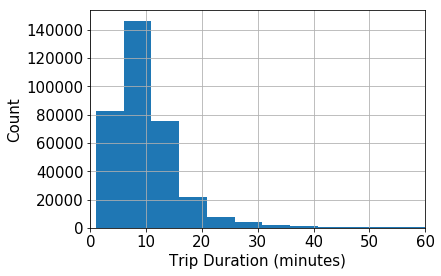

In [9]:
tripData['tripDuration'].hist(bins=40)
plt.xlabel('Trip Duration (minutes)',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim([0,60])

Pretty good!  It looks like people follow generally the rules, and the data looks reasonable for people who are commuting and taking quick rides in a nearby proximity.  Next, let's add in the city information to the trip data so we can get a sense of where the stations are located.

In [10]:
tripData=pd.merge(tripData, stationData[['Id','City']],  left_on='Start Station', right_on='Id', how='left')

89.762988226353% of the data is from San Francisco.


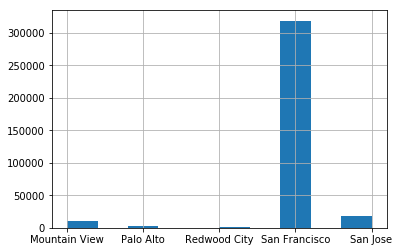

In [11]:
tripData['City'].hist()
print(str(100-100*len(tripData[tripData['City']!='San Francisco'])/len(tripData[tripData['City']=='San Francisco']))+'% of the data is from San Francisco.')
#tripData=tripData[tripData['City']=='San Francisco']
weatherData=weatherData[weatherData.Zip==94107]#94107 is San Francisco's zip code

San Francisco far outweighs all of the other cities in ridership.

Right now, we have information about the numerical day of the month for bike rentals.  The named day of the week is probably more inforamtive than the day of the month, as people are mostly working Monday-Friday and not working Saturday-Sunday.  We'll make a column to label the day of the week.

In [12]:
#DOW = Day of Week
tripData['Start DOW']=tripData['Start Date'].dt.weekday_name
tripData['End DOW']=tripData['End Date'].dt.weekday_name

Now let's get to making a rate out of our Starts (taking a bike out of a station) and our Ends (returning a bike to a station).  An End will be positive since it will add one bike to the desination stations and the Starts will will be negative since they take a bike out of the origin station.  With this, we can sum our positives and negatives to see net influx/outflow from each station.

In [13]:
bikesOut=dict()
for i in set(tripData['Start Station']):
    bikesOut[i]=tripData['Start Date'][tripData['Start Station']==i][::-1]#reverse to get in ascending chronological order
    
bikesIn=dict()
for i in set(tripData['End Station']):
    bikesIn[i]=tripData['End Date'][tripData['End Station']==i][::-1]#reverse to get in ascending chronological order

ratevar=dict()
for i in list(bikesOut.keys()):
    bikesIncrease=np.ones((bikesIn[i].shape[0],))
    bikesDecrease=-np.ones((bikesOut[i].shape[0],))
    addsubarray=np.concatenate((bikesIncrease,bikesDecrease),axis=0)
    allbikes=pd.concat([bikesIn[i],bikesOut[i]])#.tolist()
    #print(allbikes)
    
    sortedind=np.argsort(allbikes)
    sortbikes=np.sort(allbikes)
    #sortedind=[ii[0] for ii in sorted(enumerate(allbikes), key=lambda x:x[1])]
    #allbikes=allbikes[sortedind]
    addsubarray=addsubarray[sortedind]
    ratevar[i]=[sortbikes,addsubarray]

Now, let's have a look to see if there's any effect of the time of year on bike rentals.

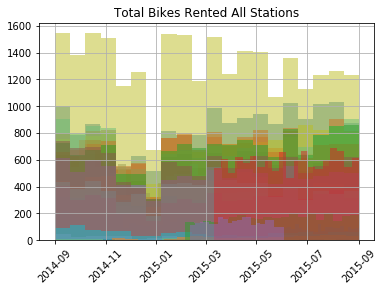

In [14]:
plt.Figure()
for i in list(bikesOut.keys()):
    bikesOut[i].hist(xrot=45,alpha=0.5,bins=20)
plt.title('Total Bikes Rented All Stations')
plt.show()

It looks like there is a dip at a lot of the stations around December.  If the Bay Area is like NYC, I expect it's due to people going home to visit their families and the city emptying out.  Additionally, the colder and generally worse weather could cause less people to ride bikes.  We'll try to preserve the most pertinent parts of the time and weather information.

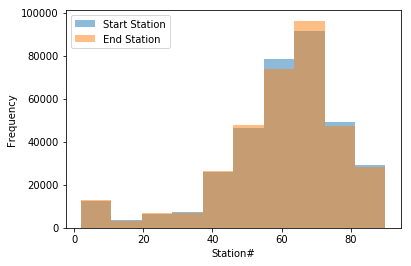

In [15]:
tripData['Start Station'].plot(kind='hist',alpha=0.5,label='Start Station')
tripData['End Station'].plot(kind='hist',alpha=0.5,label='End Station')
plt.xlabel('Station#')
plt.legend()

Some stations seem to be much more popular than others.  Let's take a look at where stations 60-75 are.

In [16]:
popularStations=list()
for i in range(60,76):
    if i in set(stationData['Id']):#not all of the sequential numbers are actual station IDs
        popularStations.append(str(stationData[stationData['Id']==i]['Name'].values))
print(', '.join(popularStations))

['Embarcadero at Sansome'], ['2nd at Townsend'], ['2nd at Folsom'], ['Howard at 2nd'], ['2nd at South Park'], ['Townsend at 7th'], ['South Van Ness at Market'], ['Market at 10th'], ['Yerba Buena Center of the Arts (3rd @ Howard)'], ['San Francisco Caltrain 2 (330 Townsend)'], ['San Francisco Caltrain (Townsend at 4th)'], ['Powell at Post (Union Square)'], ['Civic Center BART (7th at Market)'], ['Grant Avenue at Columbus Avenue'], ['Steuart at Market'], ['Mechanics Plaza (Market at Battery)']


I'm not familiar with the Bay Area, but it looks like these popular stations are located near other types of transit, tourist attractions and places where young people hang out.  These correspond with more walkable areas that make a bike feasible.  These are also places where people tend to spend their free time (i.e. not just pass through).  This information should be mostly encoded into the stationID.

Finally, we'll calculate our rates.  We'll group the Start Dates and Stations into one variable and the End Dates and Stations into another and count the unique tripIDs in both cases.  From these, we can simply subtract the Starts from the Ends and that will give us our net inflow (negative means net outflow) to a station.

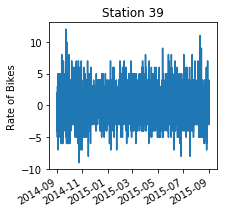

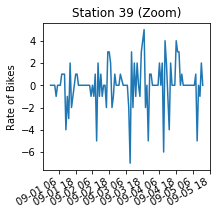

In [17]:
tripData['Start Date']=tripData['Start Date'].dt.round('H')
tripData['End Date']=tripData['End Date'].dt.round('H')
tripData.head()
groupHourStart=tripData.groupby(['Start Date','Start Station']).count()['Trip ID']
groupHourEnd=tripData.groupby(['End Date','End Station']).count()['Trip ID']
groupHourStart=groupHourStart.unstack().fillna(0)
groupHourEnd=groupHourEnd.unstack().fillna(0)
groupInOut=groupHourEnd.subtract(groupHourStart,fill_value=0)
groupInOutcumsum=groupInOut.cumsum()
#As an example:
stationid=39
groupInOut[stationid].plot(figsize=(3,3))
plt.ylabel('Rate of Bikes')
plt.title('Station '+str(stationid))
plt.show()
groupInOut[stationid][0:100].plot(figsize=(3,3))
plt.ylabel('Rate of Bikes')
plt.title('Station '+str(stationid)+' (Zoom)')
plt.show()


In [18]:
tripData.groupby(['Start Date','Start Station'])

Now, we can start looking at our features and deciding what we need and don't need.  The Events column (which specifies major weather events) contains a lot of NaN's.  My assumption is that these NaN's mean that the weather was temperate.  I'm going to replace the NaN's with 'noevent' so our classifiers have something to look at.  Then I'll modify the format of features and drop some features to make the analysis easier.

In [19]:
weatherData.loc[weatherData['Events'].isnull(), 'Events'] = 'noevent'
weatherData.head()
weatherData.keys()
#convert dates from string to datetime
weatherData['Date']=pd.to_datetime(weatherData['Date'],format='%d/%m/%Y')
weatherData['Date']=weatherData['Date'].dt.date

In [20]:
#make a 'Date' column
tripData['Date']=tripData['Start Date'].dt.date

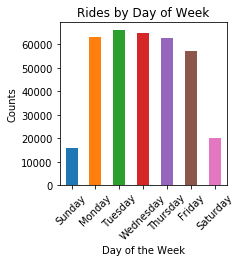

In [21]:
tripDOWstart=tripData.groupby('Start DOW').count()['Trip ID']
orderdays=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
tripDOWstart[orderdays].plot(kind='bar',figsize=(3,3))
plt.xlabel('Day of the Week')
plt.ylabel('Counts')
plt.title('Rides by Day of Week')
plt.xticks(rotation=45)
plt.show()

Let's see how the Bay Area's weather looks throughout the year.

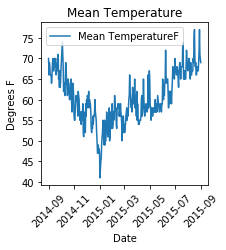

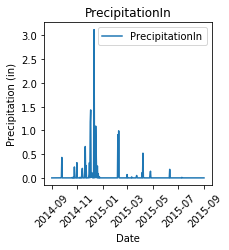

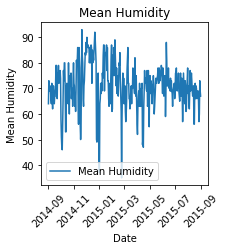

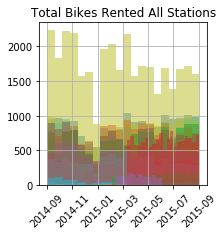

In [22]:
weatherData.plot(x='Date',y='Mean TemperatureF',figsize=(3,3))
plt.title('Mean Temperature')
plt.ylabel('Degrees F')
plt.xticks(rotation=45)
plt.show()

weatherData.plot(x='Date',y='PrecipitationIn',figsize=(3,3))
plt.title('PrecipitationIn')
plt.ylabel('Precipitation (in)')
plt.xticks(rotation=45)
plt.show()

weatherData.plot(x='Date',y='Mean Humidity',figsize=(3,3))
plt.title('Mean Humidity')
plt.ylabel('Mean Humidity')
plt.xticks(rotation=45)
plt.show()

for i in list(bikesOut.keys()):
    bikesIn[i].hist(xrot=45,alpha=0.5,bins=20,figsize=(3,3))
plt.title('Total Bikes Rented All Stations')
plt.show()

Above, I've plotted various weather conditions over time and also replotted an earlier figure showing total bikes rented from all stations throughout the year.  In addition to the fact that many people are probably going home to visit family for the holidays, the weather conditions also become less favorable for bike riding in November-March.   

# Modelling Approach

We want to predict the bike in/out rate from any given station, based on key information.  To do this, we need some sort of regression.  Given that we have categorical variables in this dataset, a tree classifier is the obvious choice. H2O is able to handle categorical variables well without the need for one-hot encoding (and its associated speed/memory performance hit) them beforehand.  Next, we'll try a few different tree based classifiers to see how they do on predicting stock flow at the bike stations.

For this analysis, I'm going to train two separate models: one for the bikes coming in to stations (Ends) and the other for bikes leaving stations (Starts).  After doing this, we'll be able to predict the rate of bikes going into and out of each stations based on the other features.  For the staff of the bike share, they'll be able to see when the bikes into a station (Ends) differ siginificanlty from the bikes leaving a station (Starts), thus being able to see where stock needs to be supplemented or removed.

An additional advantage of using this two model approach, is that the rates may be treated as a Poisson process.  If I were to use the net rate (Ends-Starts), I'd have negative and positive integers centered on 0, which complicates the modelling of rate variables.

In [23]:
weatherData['DatePd']=pd.to_datetime(weatherData['Date'])
weatherData['YearMonthDay'] = weatherData['DatePd'].apply(lambda x:x.strftime('%Y%m%d'))

To match up our weather data with our rate data we need to make a new dataframe with rows corresponding to our rate dataframes.

In [24]:
import datetime
convertWeatherData=True
if convertWeatherData:
    print(type(groupInOut.index[0]))
    weatherData['DatePd']=pd.to_datetime(weatherData['Date'])
    weatherData['YearMonthDay'] = weatherData['DatePd'].apply(lambda x:x.strftime('%Y%m%d'))
    orderWeatherDf=pd.DataFrame(columns=weatherData.keys())
    orderWeatherDfStart=pd.DataFrame(columns=weatherData.keys())
    orderWeatherDfEnd=pd.DataFrame(columns=weatherData.keys())
    counter=1
    for i in groupInOut.index:
        orderWeatherDf=orderWeatherDf.append(weatherData[weatherData['YearMonthDay']==i.strftime('%Y%m%d')])
        counter+=1
    counter=1
    for i in groupHourStart.index:
        orderWeatherDfStart=orderWeatherDfStart.append(weatherData[weatherData['YearMonthDay']==i.strftime('%Y%m%d')])
        counter+=1
    counter=1
    for i in groupHourEnd.index:
        orderWeatherDfEnd=orderWeatherDfEnd.append(weatherData[weatherData['YearMonthDay']==i.strftime('%Y%m%d')])
        counter+=1
    
    pickle.dump(orderWeatherDf,open(os.getcwd()+'/pickles/orderWeatherDf.pickle','wb'))
    pickle.dump(orderWeatherDfStart,open(os.getcwd()+'/pickles/orderWeatherDfStart.pickle','wb'))
    pickle.dump(orderWeatherDfEnd,open(os.getcwd()+'/pickles/orderWeatherDfEnd.pickle','wb'))
else:#save time calculating by loading pickles
    orderWeatherDf=pickle.load(open(os.getcwd()+'/pickles/orderWeatherDf.pickle','rb'))
    orderWeatherDfStart=pickle.load(open(os.getcwd()+'/pickles/orderWeatherDfStart.pickle','rb'))
    orderWeatherDfStart=pickle.load(open(os.getcwd()+'/pickles/orderWeatherDfEnd.pickle','rb'))

<class 'pandas._libs.tslib.Timestamp'>


Let's also separate out the month and hour values to make them separate features.  Along with the day of week (DOW) data, this will give us three distinct features which encode time.

In [25]:
orderWeatherDf['Month']=pd.Series(pd.to_datetime(groupInOut.index)).dt.month#orderWeatherDf['DatePd']
orderWeatherDf['Hour']=pd.Series(pd.to_datetime(groupInOut.index)).dt.hour
#orderWeatherDf['Day']=orderWeatherDf['DatePd'].dt.day
orderWeatherDf['DOW']=pd.Series(pd.to_datetime(groupInOut.index)).dt.weekday_name#orderWeatherDf['DatePd']

orderWeatherDfStart['Month']=pd.Series(pd.to_datetime(groupHourStart.index)).dt.month#orderWeatherDf['DatePd']
orderWeatherDfStart['Hour']=pd.Series(pd.to_datetime(groupHourStart.index)).dt.hour
#orderWeatherDf['Day']=orderWeatherDf['DatePd'].dt.day
orderWeatherDfStart['DOW']=pd.Series(pd.to_datetime(groupHourStart.index)).dt.weekday_name#orderWeatherDf['DatePd']

orderWeatherDfEnd['Month']=pd.Series(pd.to_datetime(groupHourEnd.index)).dt.month#orderWeatherDf['DatePd']
orderWeatherDfEnd['Hour']=pd.Series(pd.to_datetime(groupHourEnd.index)).dt.hour
#orderWeatherDf['Day']=orderWeatherDf['DatePd'].dt.day
orderWeatherDfEnd['DOW']=pd.Series(pd.to_datetime(groupHourEnd.index)).dt.weekday_name#orderWeatherDf['DatePd']

There are a lot of variables that correlate in our data set.  We're going to keep the means and leave out data that is presumably erroneous to the bike share.

In [26]:
dropCols=['Date', 'Max TemperatureF', 'Min TemperatureF',
        'Max Dew PointF', 'Min DewpointF', 'Max Humidity','MeanDew PointF',
        'Min Humidity', 'Max Sea Level PressureIn',
        'Min Sea Level PressureIn','Mean Sea Level PressureIn',
        'Max VisibilityMiles',  'Min VisibilityMiles','Mean VisibilityMiles',
        'Max Wind SpeedMPH', 'Max Gust SpeedMPH','Events',
        'CloudCover', 'WindDirDegrees', 'Zip',
        'DatePd', 'YearMonthDay']
orderWeatherDf.drop(dropCols,axis=1,inplace=True)
if orderWeatherDf.shape[0]!=groupInOut.shape[0]:
    groupInOut.drop(groupInOut.index[-1],inplace=True)
    
orderWeatherDfStart.drop(dropCols,axis=1,inplace=True)
if orderWeatherDfStart.shape[0]!=groupHourStart.shape[0]:
    groupHourStart.drop(groupHourStart.index[-1],inplace=True)
    
orderWeatherDfEnd.drop(dropCols,axis=1,inplace=True)
if orderWeatherDfEnd.shape[0]!=groupHourEnd.shape[0]:
    groupHourEnd.drop(groupHourEnd.index[-1],inplace=True)

In [27]:
orderWeatherDf = orderWeatherDf.set_index(groupInOut.index)
orderWeatherDfStart = orderWeatherDfStart.set_index(groupHourStart.index)
orderWeatherDfEnd = orderWeatherDfEnd.set_index(groupHourEnd.index)

Now, let's make sure the rates data is a form where it can be safely merged with the weather data

In [28]:
allRates=pd.DataFrame(columns=['Station','Rate'])
for i in groupInOut.keys():
    x=pd.DataFrame(columns=['Station','Rate'])
    x['Station']=pd.Series(i*np.ones((groupInOut[i].shape[0])), index=groupInOut[i].index)
    x['Rate']=groupInOut[i]
    allRates=allRates.append(x,ignore_index=True)

weatherAll=pd.DataFrame(columns=list(orderWeatherDf.keys()))
for i in groupInOut.keys():
    weatherAll=weatherAll.append(orderWeatherDf)

if weatherAll.shape[0]!=allRates.shape[0]:
    allRates.drop(allRates.index[-1],inplace=True)

weatherAll.set_index(allRates.index,inplace=True)

startRates=pd.DataFrame(columns=['Station','Rate'])
for i in groupHourStart.keys():
    x=pd.DataFrame(columns=['Station','Rate'])
    x['Station']=pd.Series(i*np.ones((groupHourStart[i].shape[0])), index=groupHourStart[i].index)
    x['Rate']=groupHourStart[i]
    startRates=startRates.append(x,ignore_index=True)
    
weatherStarts=pd.DataFrame(columns=list(orderWeatherDfStart.keys()))
for i in groupHourStart.keys():
    weatherStarts=weatherStarts.append(orderWeatherDfStart)

if weatherAll.shape[0]!=allRates.shape[0]:
    allRates.drop(allRates.index[-1],inplace=True)

endRates=pd.DataFrame(columns=['Station','Rate'])
for i in groupHourEnd.keys():
    x=pd.DataFrame(columns=['Station','Rate'])
    x['Station']=pd.Series(i*np.ones((groupHourEnd[i].shape[0])), index=groupHourEnd[i].index)
    x['Rate']=groupHourEnd[i]
    endRates=endRates.append(x,ignore_index=True)
    
weatherEnd=pd.DataFrame(columns=list(orderWeatherDfEnd.keys()))
for i in groupHourEnd.keys():
    weatherEnd=weatherEnd.append(orderWeatherDfEnd)

if weatherEnd.shape[0]!=endRates.shape[0]:
    allRates.drop(endRates.index[-1],inplace=True)
    
    
#weatherAll.set_index(allRates.index,inplace=True)
weatherStarts.set_index(startRates.index,inplace=True)
weatherEnd.set_index(endRates.index,inplace=True)

Let's combine our weather data and our station/rate data into a single dataframe.

In [29]:
frames=[weatherAll,allRates]
combineAll=pd.concat(frames,axis=1)

framesStart=[weatherStarts,startRates]
combineStarts=pd.concat(framesStart,axis=1)

framesEnd=[weatherEnd,endRates]
combineEnd=pd.concat(framesEnd,axis=1)

Now let's see if the features we've chosen covary (and thus don't provide additional information)

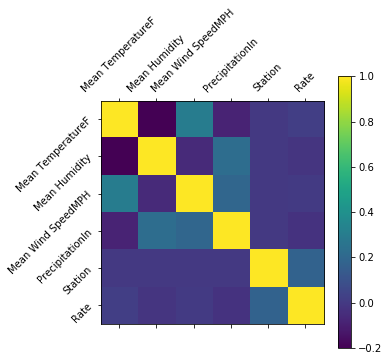

In [30]:
def plot_corr(df):
    size=df.shape[1]
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(5,5))
    cax = ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns,rotation=45);
    plt.yticks(range(len(corr.columns)), corr.columns,rotation=45);

    fig.colorbar(cax)
plot_corr(combineStarts)

So, according to the correlation matrix above, it seems that the measures I've chosen don't covary too much, meaning they could provide distinct types of information about the ridership.

Let's take a quick look at how (bike rentals)/hour looks for the rental data.

(0, 15)

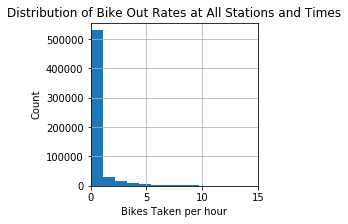

In [31]:
combineStarts['Rate'].hist(bins=40,figsize=(3,3))
plt.title('Distribution of Bike Out Rates at All Stations and Times')
plt.xlabel('Bikes Taken per hour')
plt.ylabel('Count')
plt.xlim([0,15])

Ok, so most of the time there's about 1 bike rental per hour.  Higher rates are more rare...pretty Poissonian!

Now, let's train some regressors that predict the number of bikes leaving a station (Starts).  These numbers represent negative bike stock from a station.  I'm going to try two very different types of tree regressors, gradient boosted trees and random forest.  These two models use the same basis classifier (decision trees) in very different ways.  Gradient boosting works by iterative training weak classifiers (shallow trees) on the residuals of previous trees while random forest boostraps the data to train deep trees in parallel.  Let's see if they work differently in our prediciton.

In [32]:
import h2o
from h2o.estimators import H2OGradientBoostingEstimator
from h2o.estimators import H2ORandomForestEstimator
h2o.init()

featurelabels=list(combineStarts.keys())
featurelabels.remove('Rate')

weatherRateFrameh2o = h2o.H2OFrame(combineStarts)
trainStart, testStart = weatherRateFrameh2o.split_frame(ratios=[0.80])#80/20 split train/test
trainStart['Month']=trainStart['Month'].asfactor()
testStart['Month']=testStart['Month'].asfactor()
trainStart['DOW']=trainStart['DOW'].asfactor()
testStart['DOW']=testStart['DOW'].asfactor()
trainStart['Station']=trainStart['Station'].asfactor()
testStart['Station']=testStart['Station'].asfactor()

#use gradient boosted regressor
bikerate_GBMStart = H2OGradientBoostingEstimator(ntrees=10,max_depth=10,learn_rate=0.2)#ntrees=200,max_depth=10,learn_rate=0.2
bikerate_GBMStart.train(x=featurelabels,y='Rate',training_frame=trainStart)

#use random forest regressor
bikerate_RFStart = H2ORandomForestEstimator(ntrees=50, max_depth=20, nfolds=10)
bikerate_RFStart.train(x=featurelabels,y='Rate',training_frame=trainStart)


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_121"; OpenJDK Runtime Environment (Zulu 8.20.0.5-linux64) (build 1.8.0_121-b15); OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-linux64) (build 25.121-b15, mixed mode)
  Starting server from /home/ben/anaconda3/envs/insight/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpb327scia
  JVM stdout: /tmp/tmpb327scia/h2o_ben_started_from_python.out
  JVM stderr: /tmp/tmpb327scia/h2o_ben_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,16 days
H2O cluster name:,H2O_from_python_ben_f3azb7
H2O cluster total nodes:,1
H2O cluster free memory:,3.457 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


Now I'll train a model that predicts the bikes coming into a station (Ends).  These values represent net positive stock coming into a station.

In [33]:
#h2o.init()
featurelabels=list(combineEnd.keys())
featurelabels.remove('Rate')

weatherRateFrameh2o = h2o.H2OFrame(combineEnd)
trainEnd, testEnd = weatherRateFrameh2o.split_frame(ratios=[0.80])#80/20 split train/test

trainEnd['Month']=trainEnd['Month'].asfactor()
testEnd['Month']=testEnd['Month'].asfactor()
trainEnd['DOW']=trainEnd['DOW'].asfactor()
testEnd['DOW']=testEnd['DOW'].asfactor()
trainEnd['Station']=trainEnd['Station'].asfactor()
testEnd['Station']=testEnd['Station'].asfactor()
    
#use gradient boosted regressor
bikerate_GBMEnd = H2OGradientBoostingEstimator(ntrees=10,max_depth=10,learn_rate=0.2)#ntrees=200,max_depth=10,learn_rate=0.2
bikerate_GBMEnd.train(x=featurelabels,y='Rate', training_frame=trainEnd)

#use random forest regressor
bikerate_RFEnd = H2ORandomForestEstimator(ntrees=50, max_depth=20, nfolds=10)
bikerate_RFEnd.train(x=featurelabels,y='Rate',training_frame=trainEnd)

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


# Performance Analysis

## Statisitics on regression of bikes leaving stations per hour:

In [363]:
performance_gbmStart = bikerate_GBMStart.model_performance(testStart)
print('::::::::::::::::::::::::::GBM::::::::::::::::::::::::::::::::')
print('Standard Deviation of test: '+str(testStart.as_data_frame()['Rate'].std()))
print('Root Mean Squared Error of model on test: '+str(performance_gbmStart.rmse()))
print('R^2 = '+str(performance_gbmStart.r2()))
print(' ')

performance_rfStart=bikerate_RFStart.model_performance(testStart)
print('::::::::::::::::::::::::::RF::::::::::::::::::::::::::::::::')
print('Standard Deviation of test: '+str(testStart.as_data_frame()['Rate'].std()))
print('Root Mean Squared Error of model on test: '+str(performance_rfStart.rmse()))
print('R^2 = '+str(performance_rfStart.r2()))

::::::::::::::::::::::::::GBM::::::::::::::::::::::::::::::::
Standard Deviation of test: 1.71826040049
Root Mean Squared Error of model on test: 1.554620374166177
R^2 = 0.18139507453680337
 
::::::::::::::::::::::::::RF::::::::::::::::::::::::::::::::
Standard Deviation of test: 1.71826040049
Root Mean Squared Error of model on test: 1.5448908132240688
R^2 = 0.1916094565012113


## Feature importance of bikes leaving stations

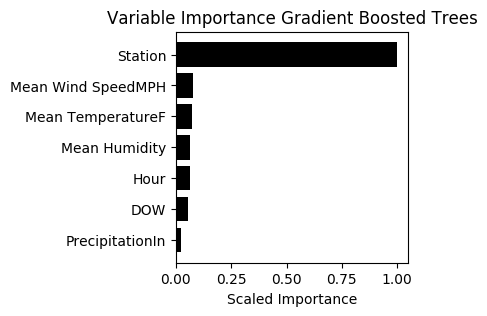

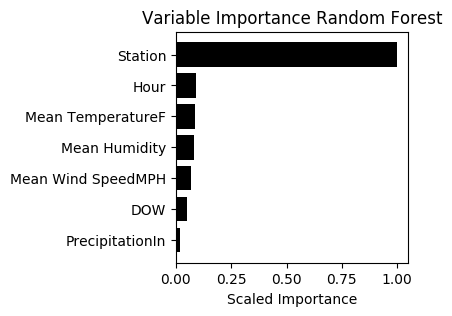

In [364]:
import matplotlib.pyplot as plt
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(3,3))
variables = bikerate_GBMStart._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = bikerate_GBMStart._model_json['output']['variable_importances']['scaled_importance']
ax.barh(y_pos, scaled_importance, align='center', color='black', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance Gradient Boosted Trees')
plt.show()

fig, ax = plt.subplots(figsize=(3,3))
variables = bikerate_RFStart._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = bikerate_RFStart._model_json['output']['variable_importances']['scaled_importance']
ax.barh(y_pos, scaled_importance, align='center', color='black', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance Random Forest')
plt.show()

## Statisitics on regression of bikes coming into stations per hour:

In [366]:
performance_gbmEnd = bikerate_GBMEnd.model_performance(testEnd)
print('::::::::::::::::::::::::::GBM::::::::::::::::::::::::::::::::')
print('Standard Deviation of test: '+str(testEnd.as_data_frame()['Rate'].std()))
print('Root Mean Squared Error of model on test: '+str(performance_gbmEnd.rmse()))
print('R^2 = '+str(performance_gbmEnd.r2()))
print(' ')

performance_rfEnd=bikerate_RFEnd.model_performance(testEnd)
print('::::::::::::::::::::::::::RF::::::::::::::::::::::::::::::::')
print('Standard Deviation of test: '+str(testEnd.as_data_frame()['Rate'].std()))
print('Root Mean Squared Error of model on test: '+str(performance_rfEnd.rmse()))
print('R^2 = '+str(performance_rfEnd.r2()))


::::::::::::::::::::::::::GBM::::::::::::::::::::::::::::::::
Standard Deviation of test: 1.7777045992
Root Mean Squared Error of model on test: 1.5834207972612888
R^2 = 0.2066275974204953
 
::::::::::::::::::::::::::RF::::::::::::::::::::::::::::::::
Standard Deviation of test: 1.7777045992
Root Mean Squared Error of model on test: 1.5690660841909063
R^2 = 0.2209472408503128


## Feature importance of bikes coming into stations

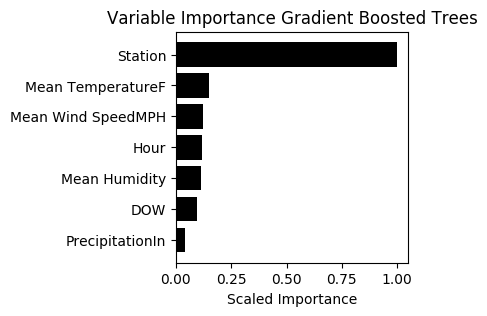

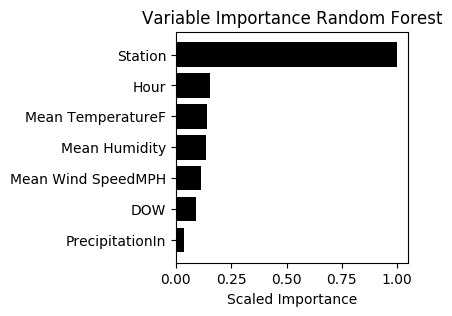

In [260]:
import matplotlib.pyplot as plt
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(3,3))
variables = bikerate_GBMEnd._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = bikerate_GBMEnd._model_json['output']['variable_importances']['scaled_importance']
ax.barh(y_pos, scaled_importance, align='center', color='black', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance Gradient Boosted Trees')
plt.show()

fig, ax = plt.subplots(figsize=(3,3))
variables = bikerate_RFEnd._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = bikerate_RFEnd._model_json['output']['variable_importances']['scaled_importance']
ax.barh(y_pos, scaled_importance, align='center', color='black', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance Random Forest')
plt.show()

Now that I have a model to predict both the influx and outflow of bikes from a given station, bike share employees can look at the predicted rates to determine whether, in a given hour, there will be a stock problem (either too many bikes or too few).  Looking at our standard deviations vs our RMSE's and R^2's we can see that we did better than guessing the mean, but not great.  

The RMSE was about ~1.55 for both gradient boosting and random forest for predicting outgoing bike rates corresponding to an R^2 value of about 0.19.

The RMSE was about ~1.58 for both gradient boosting and random forest for predicting outgoing bike rates corresponding to an R^2 value of about 0.21.

# Conclusions

In this notebook, I built classifiers that can be used to estimate the rate of bikes coming into and going out of a station in the Bay Area Bike Share program.  The model takes parameters about the weather,time of day, day of the week, time of year and station to assess whether a surplus or deficit of bikes is likely to occur within an hour.  I assessed two different regression models: gradient boosted trees and random forest and found that they performed similarly on the task.  The R^2 values I obtained from the ingoing and outgoing rentals per station were not as well fit as I would've liked.  I suspect that my focus on weather features was misguided and that San Francisco's famously temperate weather precludes these features from having a drastic influence on people's willingness to be outdoors.  In a different geography (say, NYC), these features may prove to be more predictive.

Overall, the station location itself was the most predictive feature for incoming and outgoing bikes at stations across the bike share.  This indicates that proximity to city amenities is the most informative feature in the case of the Bay Area.  Future iterations of this analysis should include data from outside sources that include more detail about population density, retail density, tourist density and residential density.  

# Potential Improvement

## Data

The first area of improvement is to more intelligently parse the data.  In particular, introducing a variable that identifies San Francisco as the highest ridership (by far) could inform the model differences in ridership among stations.  I should also take a look at why some of the trip durations were so long in the dataset.  Could I somehow predict when a bike is going to be lost?  I didn't do much in the way of analysis of the links between stations, so constructing a graph to determine where future funding would be best spent as well as how infrastructure could facilitate flow between stations would be worthwhile. On the customer side, I didn't look into how subscribers travel differently from non-subscribers.  This analysis could be important for understanding areas to target to attract more subscribers and it could tell us more about tourism and how we could generate more tourism dollars by analyzing who the non-subscribers are. 

Additionally, some features could be combined into composite features, like dew point and humidity for example.  Many features obviously correlate and in this project I decided to just drop features that were correlated.  These could instead be organized into higher order terms.  On the other hand, the weather data seemed to be much less informative of ridership than the station location itself.  This could be a particular geographical feature, as San Francisco is known to have great, mild weather year-round.  It could be interesting to see if more informative measures could be gathered from outside data sets.  A few ideas I have: retail density, proximity to institutions (universities, muesums, etc) and population density.  In some sense, these are encoded into the station Id's themselves, but we might be able to build more informative models if we could add some more detailed data about them to the feature space.

## Model

I tried two different tree-based regression models in this project because they make working with categorical data straightforward and interpretable.  Due to time constraints I wasn't able to perform cross validation and subsequent hyperparameter tuning, so that would be an obvious focus for future iterations.  I'd like to see how many trees in the GBM I can get away with, as well as examining regularization of the GBM. For Random Forest, the obvious hyperparameters like tree depth, number of trees and sampling should be more thoroughly tuned for proper comparison with the GBM.  

In the end, my models did not explain a great deal of the variance in the data.  Weather conditions did not turn out to be as informative a set of features as I hoped for.  As I mentioned above, searching for different features from outside datsets may help identify the relevant variables that most affect bike share ridership. 